In [1]:
import numpy as np
import pandas as pd
import nltk
from collections import defaultdict
import seaborn as sn
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score,fbeta_score,precision_score,recall_score
from sklearn.metrics.pairwise import cosine_similarity
import gensim as gn
import gensim.downloader as api
from gensim.models import keyedvectors

In [2]:
print(gn.__version__)

4.2.0


In [3]:
nltk.download('brown')
nltk.download('universal_tagset')

import gensim.downloader as api

#online loading from api
from gensim.models import KeyedVectors
path = "./GoogleNews-vectors-negative300.bin"
word2vec = KeyedVectors.load_word2vec_format(path, binary=True)

#local loading
# word2vec = api.load('word2vec-google-news-300')

[nltk_data] Downloading package brown to
[nltk_data]     C:\Users\cheta\AppData\Roaming\nltk_data...
[nltk_data]   Package brown is already up-to-date!
[nltk_data] Downloading package universal_tagset to
[nltk_data]     C:\Users\cheta\AppData\Roaming\nltk_data...
[nltk_data]   Package universal_tagset is already up-to-date!


In [4]:
# Attempt 2

In [5]:
global_sentences = nltk.corpus.brown.tagged_sents(tagset='universal')
start_alpha = '^'
end_alpha = '$'
global_sentences=[global_sentences[i] for i in range(len(global_sentences))]

for i in range(len(global_sentences)):
  
  global_sentences[i].insert(0,('^','^'))
  global_sentences[i].insert(len(global_sentences[i]),('$','$'))
 

In [6]:
def test_split(p):
  k = len(global_sentences)//5
  test_sentences = global_sentences[p*k:(p+1)*k+1]
  train_sentences = global_sentences[0:p*k] + global_sentences[(p+1)*k+1:]

  return test_sentences,train_sentences

In [7]:
def def_value():
  return 0
def def_value_float():
  return 0.00

#all useful Variables initialisation
tag_list=set()
word_list=set()
count_of_tags=defaultdict(def_value)
tag_to_tag_map=defaultdict(def_value)
epsilon = 1e-10
# transition_prob_matrix = np.array()
tag_to_word_map=defaultdict(def_value)

In [8]:
# print("before ",tag_list,word_list,count_of_tags,tag_to_tag_map,tag_to_word_map)

In [9]:
def preprocess_data(train_sentences):
  for sentences in train_sentences:
    for word in sentences:
      tag_list.add(word[1])
      word_list.add(word[0])
      if(word[1] in count_of_tags):
        count_of_tags[word[1]]+=1
      else:
        count_of_tags[word[1]]=1
  tag_as_first=defaultdict(def_value)
  tag_as_second=defaultdict(def_value)
  prob_tag_to_tag=defaultdict(def_value)
  
  for i in tag_list:
    tag_as_first[i]=0
    tag_as_second[i]=0
    for j in tag_list:
      tag_to_tag_map[(i,j)]=0

  for sentences in train_sentences:
    for i in range(len(sentences)-1):
      tag_to_tag_map[(sentences[i][1],sentences[i+1][1])]+=1
      tag_as_first[sentences[i][1]]+=1
      tag_as_second[sentences[i+1][1]]+=1

  for i in tag_list:
    for j in tag_list:
      prob_tag_to_tag[(i,j)]=(tag_to_tag_map[(j,i)]+epsilon)/(tag_as_first[j] + len(tag_list)*epsilon)
                

  for sentences in train_sentences:
    for word in sentences:
      if(word in tag_to_word_map):
        tag_to_word_map[word]+=1
      else:
        tag_to_word_map[word]=1

  transition_prob_matrix = np.array([[prob_tag_to_tag[(col,row)] for col in tag_list] for row in tag_list])
  
  return transition_prob_matrix
  

In [10]:
# print("before ",tag_list,word_list,count_of_tags,tag_to_tag_map,tag_to_word_map)

In [11]:
# print(transition_prob_matrix)

In [12]:
def emission_array(sentence):
  prob_word_to_tag = defaultdict(def_value_float)
  sentence = sentence.tolist()
  for word in sentence:
    for tag in tag_list:
      prob_word_to_tag[(word,tag)]=(tag_to_word_map[(word,tag)]+epsilon)/(count_of_tags[tag]+len(tag_list)*epsilon)
      

  # print(prob_word_to_tag)
  emission_prob_matrix = np.array([[prob_word_to_tag[(word,tag)] for word in sentence] for tag in tag_list])
  # print(emission_prob_matrix.shape)
  return emission_prob_matrix

In [13]:
def sentence_array(sentence):
  st = []
  for i in sentence:
    st.append(i[0])
  inpt = np.array(st)
  return inpt

In [14]:
def viterbi(tran,emmi,sent,tag_list):
  
  c = np.zeros((tran.shape[0],sent.shape[0]),dtype=np.float64)
  d = np.zeros((tran.shape[0],sent.shape[0]),dtype=np.int32)
  # print(f"before {tag_list}, {type(tag_list)}")
  tag_list=np.array(list(tag_list))
  # print(f"after {tag_list}, {type(tag_list)}")
  for i in range(c.shape[0]):
    if tag_list[i] == '^':
      c[i,0] = 1.0
    d[i,0] = 0

  for j in range(1,sent.shape[0]):
    for i in range(c.shape[0]):
      mx = -np.inf
      a=0
      for k in range(c.shape[0]):
       
        c[i,j] = c[k,j-1]*tran[k,i]*emmi[i,j]
        if c[k,j-1]*tran[k,i]*emmi[i,j] > mx:
          mx = c[k,j-1]*tran[k,i]*emmi[i,j]
          a = k
      c[i,j] = mx
      d[i,j] = a

  s = -1
  mx = -1

  for i in range(c.shape[0]):
    if c[i,c.shape[1]-1] > mx:
      mx = c[i,c.shape[1]-1]
      s = i

  tag = []
  j = s
  k = d.shape[1]

  for i in range(k)[::-1]:
    tag.append(j)
    j = d[j,i]
    

  tag.reverse()
  
  return tag

In [15]:
def train(p):
  # correct=0
  # total=0
  # tally=0

  test_data,train_data = test_split(p)
  transition_matrix = preprocess_data(train_data)
  return test_data,transition_matrix,train_data
  # for sentence in train_data:
  #   if tally%5000==1:
  #     print(tally)
  #     # print(correct/total*100)
  #   sentence_matrix = sentence_array(sentence)
  #   emission_matrix = emission_array(sentence_matrix)
  #   # print(tag_list)
  #   predicted_tag = viterbi(transition_matrix,emission_matrix,sentence_matrix,tag_list)
  #   tally+=1
  # print("done")
  # return test_data,transition_matrix,train_data
  

In [16]:


# a = buildconfusion()
def plotcm(a):
  tg_lst = np.array(list(tag_list))
  i,j = np.where(tg_lst=='^')[0][0], np.where(tg_lst=='$')[0][0]

  a = np.delete(a,int(max(i,j)),0)
  a = np.delete(a,int(max(i,j)),1)
  a = np.delete(a,int(min(i,j)),0)
  a = np.delete(a,int(min(i,j)),1)

  precision_matrix = np.diagonal(a/np.sum(a,axis=0))
  recall_matrix = np.diagonal(a/np.sum(a,axis=1))
  F1_matrix = 2*precision_matrix*recall_matrix/(precision_matrix+recall_matrix)
  print(precision_matrix)
  print(recall_matrix)
  print(F1_matrix)

  b = tg_lst[tg_lst!='^']
  b = b[b!='$']
  df_cm = pd.DataFrame(a, index = [i for i in b.tolist()],
                    columns = [i for i in b.tolist()])
  plt.figure(figsize = (10,7))
  sn.heatmap(df_cm/np.sum(df_cm), annot = True, cmap = plt.cm.Blues)
  plt.show()

In [17]:
def test_model(test_data,transition_prob_matrix,train_data):
  correct=0
  total=0
  tally=0
  conf = np.zeros((len(tag_list),len(tag_list)),dtype=np.int32)
  y_true=[]
  predicted_list = []

  # ------------------------------------------------------------------------------#
  map={}
  for sentence in train_data:
    for word in sentence:
      if word[1] in map:
          map[word[1]].append(word[0])
      else:
          map[word[1]]=[word[0]]
  # print(map['NUM'])
  mean_tags={}
  for tag in tag_list:
    mean_tags[tag]=np.zeros((300,1))
    count_tags=0.1
    for word in map[tag]:
      if(word in word2vec):
        mean_tags[tag]+=word2vec[word].reshape((300,1))
        count_tags+=1
    mean_tags[tag]=mean_tags[tag]/count_tags
  # ------------------------------------------------------------------------------#

  for sentence in test_data:
    if tally%1000==1:
      # print(correct/total*100) 
      print(tally)
    sentence_matrix = sentence_array(sentence)
    emission_prob_matrix =  emission_array(sentence_matrix)
    # print(viterbi(trasition_prob_matrix,emission_prob_matrix,sentence_matrix))
    predicted_tag = viterbi(transition_prob_matrix,emission_prob_matrix,sentence_matrix,tag_list)

    # modified via word2vec---------------------------------------------#
    for ind in range(len(sentence)):
      word=sentence[ind]
      # print(word,word[0])
      if(word[0] in word_list):
        pass
      else:
        if(word[0] in word2vec):
          my_vec=word2vec[word[0]].reshape((300,1))
          value=-200
          my_tag='.'
          for tag in tag_list:
            temp=cosine_similarity(my_vec.T,mean_tags[tag].T)
            if(temp>value):
              value=temp
              my_tag=tag
          print(word,my_tag)
          tag_2 = list(tag_list)
          predicted_tag[ind]=tag_2.index(my_tag)
    # end ------------------------------------------------------------------#
    tag_by_index=[]
    # print(tag_list)
    for i in tag_list:
      tag_by_index.append(i)

    tag_data=[]
    for tag in predicted_tag:
      tag_data.append(tag_by_index[tag])
    # print(tag_data)
    
    predicted_list = predicted_list + tag_data[1:len(tag_data)-1]
    tally+=1
    temp=[]
    for i in sentence:
      # temp.append(tag_by_index.index(i[1]))
      temp.append(i[1])
    y_true = y_true + temp[1:len(temp)-1]
    
    tg_lst = np.array(tag_by_index)
    for i in range(len(predicted_tag)):
      conf[predicted_tag[i],np.where(tg_lst == sentence[i][1])[0][0]] += 1


  plotcm(conf)
  return conf,predicted_list,y_true
  
  print("done")

epoch number: 1
testing data
1
('presentments', 'NOUN') NOUN
('Durwood', 'NOUN') NOUN
('Pye', 'NOUN') NOUN
('Ivan', 'NOUN') NOUN
('inure', 'VERB') ADJ
('Merger', 'NOUN') NOUN
('jurors', 'NOUN') NOUN
('disable', 'VERB') VERB
('jurors', 'NOUN') NOUN
('appraisers', 'NOUN') NOUN
('Wards', 'NOUN') NOUN
('juries', 'NOUN') NOUN
('unmeritorious', 'ADJ') NOUN
('Regarding', 'ADP') ADP
('extern', 'NOUN') X
('employes', 'NOUN') X
('Bellwood', 'NOUN') NOUN
('Alpharetta', 'NOUN') $
('Grady', 'NOUN') NOUN
('Hartsfield', 'NOUN') NOUN
('Hartsfield', 'NOUN') NOUN
('Aug.', 'NOUN') $
('Cheshire', 'NOUN') NOUN
('amicable', 'ADJ') ADJ
('Ala.', 'NOUN') NOUN
('Hartsfield', 'NOUN') NOUN
('Pelham', 'NOUN') NOUN
('Rd.', 'NOUN') ^
('Bowden', 'NOUN') PRON
('Hartsfield', 'NOUN') NOUN
('expires', 'VERB') VERB
('Ivan', 'NOUN') NOUN
('Hartsfield', 'NOUN') NOUN
('reelection', 'NOUN') NOUN
('Snodgrass', 'NOUN') NOUN
('GOP', 'NOUN') NOUN
('Dorsey', 'NOUN') PRON
('Sen.', 'NOUN') NOUN
('Tower', 'NOUN') NOUN
('petitions', '

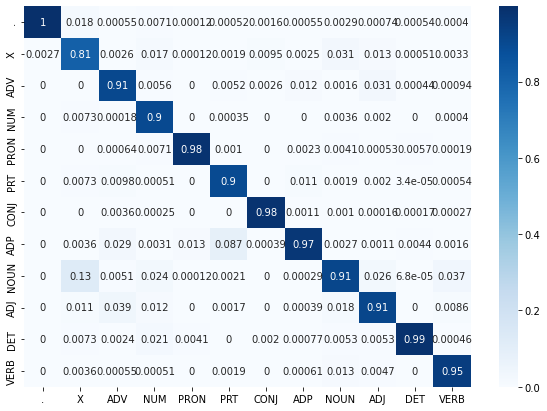

0.9460222620726013
0.9460222620726013
0.9460222620726012
0.9460222620726013
0.9460222620726012
epoch number: 2
testing data
1
1001
2001
3001
4001
5001
6001
7001
8001
9001
10001
11001
[0.99989912 0.96969697 0.90572782 0.97721438 0.9866061  0.91470278
 0.99271002 0.96895911 0.98082088 0.94971301 0.99111491 0.96239869]
[0.9968487  0.88888889 0.90377437 0.97471191 0.97435013 0.91213609
 0.99374493 0.96537037 0.97264751 0.94759515 0.99626212 0.98259141]
[0.99837158 0.92753623 0.90475004 0.97596154 0.98043981 0.91341763
 0.99322721 0.96716141 0.97671709 0.9486529  0.99368185 0.97239023]


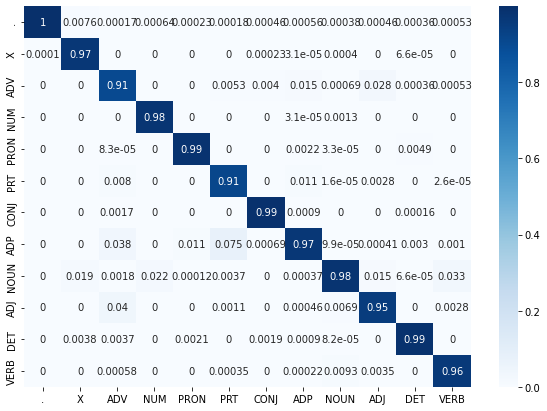

0.9729678737590873
0.9729678737590873
0.9729678737590873
0.9729678737590873
0.9729678737590873
epoch number: 3
testing data
1
1001
2001
3001
4001
5001
6001
7001
8001
9001
10001
11001
[0.99970706 0.82921348 0.91796778 0.98666074 0.98318704 0.93139842
 0.99141631 0.97020151 0.98257758 0.95805308 0.98975653 0.97044894]
[0.98739793 0.94858612 0.91186608 0.97581354 0.96857874 0.91577309
 0.9939759  0.97518378 0.97963047 0.9535031  0.99377403 0.98586679]
[0.99351437 0.88489209 0.91490676 0.98120716 0.97582822 0.92351967
 0.99269446 0.97268626 0.98110181 0.95577267 0.99176121 0.97809711]


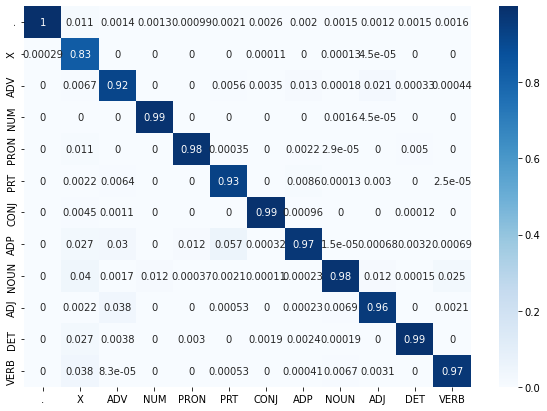

0.9760592956808687
0.9760592956808687
0.9760592956808686
0.9760592956808687
0.9760592956808686
epoch number: 4
testing data
1
1001
2001
3001
4001
5001
6001
7001
8001
9001
10001
11001
[0.99985669 0.89302326 0.91545916 0.97831978 0.98866404 0.91990252
 0.99420467 0.9684727  0.98352601 0.94871214 0.98288871 0.97514296]
[0.99650075 0.96482412 0.92030061 0.97260889 0.97253709 0.91975309
 0.99329575 0.96217753 0.97760722 0.947424   0.9946591  0.98605219]
[0.9981759  0.92753623 0.9178735  0.97545598 0.98053426 0.9198278
 0.99375    0.96531486 0.98055768 0.94806763 0.98873888 0.98056723]


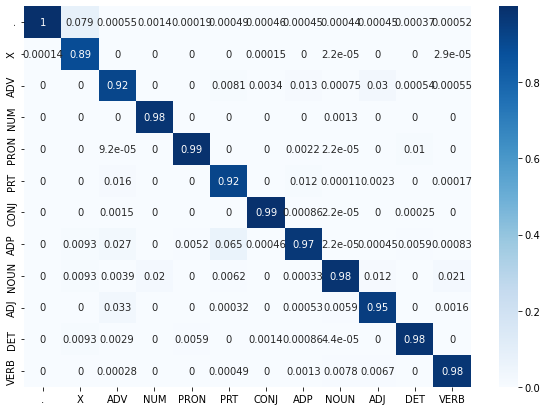

0.9752338142536069
0.9752338142536069
0.9752338142536069
0.9752338142536069
0.9752338142536069
epoch number: 5
testing data
1
1001
2001
3001
4001
5001
6001
7001
8001
9001
10001
11001
[0.99979369 0.93370166 0.91746772 0.97761194 0.98585316 0.90971902
 0.9958152  0.95595096 0.97781369 0.94277017 0.97423864 0.97754792]
[0.99780378 0.93888889 0.91144979 0.91608392 0.97748525 0.91421077
 0.9910045  0.94915437 0.97663702 0.92872851 0.98985493 0.98727051]
[0.99879775 0.93628809 0.91444885 0.94584838 0.98165138 0.91195937
 0.99340402 0.95254054 0.977225   0.93569666 0.9819847  0.98238516]


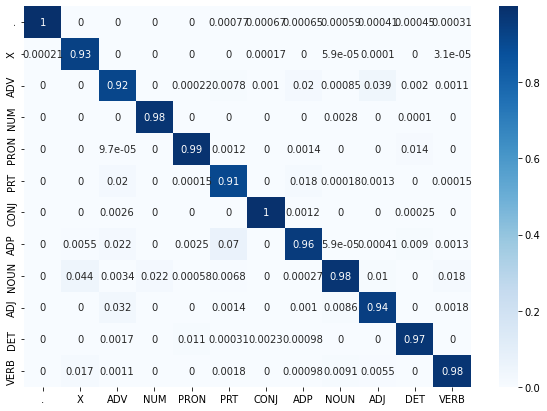

0.9720621770790874
0.9720621770790874
0.9720621770790873
0.9720621770790874
0.9720621770790873
[0.99929526 0.87672226 0.91253245 0.96022114 0.98561064 0.91478092
 0.9913775  0.96748125 0.96526332 0.94292273 0.98622169 0.96597768]
[0.99354565 0.29763663 0.90805981 0.95667361 0.96697354 0.91087225
 0.99036523 0.963654   0.97442451 0.93499704 0.99047193 0.9826206 ]
[0.99641216 0.4444036  0.91029064 0.95844409 0.97620314 0.9128224
 0.99087111 0.96556383 0.96982228 0.93894316 0.98834224 0.97422807]


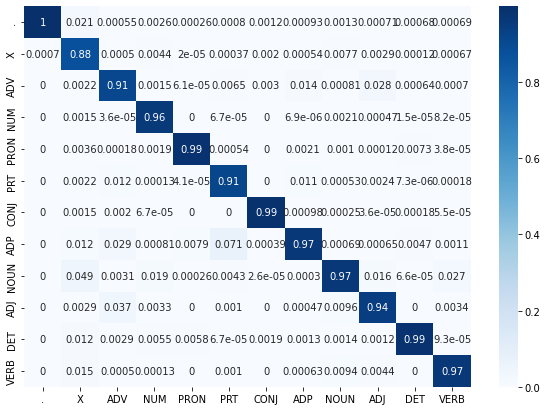

0.9684690845690502
0.9684690845690505
0.9684690845690502
0.9684690845690505
0.9684690845690505
done


In [18]:

f0_5_score=0
f1score=0
f2score=0
prec=0
recal=0
for i in range(5):
  print(f"epoch number: {i+1}")
  test_data, transition_matrix,train_data = train(i)
  # print(test_data[0])
  print("testing data")
  if i==0:
    conf,predicted_list,y_true = test_model(test_data,transition_matrix,train_data)
  else:
    temp,predicted_list,y_true = test_model(test_data,transition_matrix,train_data)
    conf = conf + temp
  # print(predicted_list[0:30])
  # print(y_true[0:30])
  print(precision_score(np.array(y_true),np.array(predicted_list),average='micro'))
  print(recall_score(np.array(y_true),np.array(predicted_list),average='micro'))
  print(fbeta_score(np.array(y_true),np.array(predicted_list),beta=0.5,average='micro'))
  # print(np.array(y_true),np.array(predicted_list)
  print(f1_score(np.array(y_true),np.array(predicted_list),average='micro'))
  print(fbeta_score(np.array(y_true),np.array(predicted_list),beta=2,average='micro'))
  f0_5_score += fbeta_score(np.array(y_true),np.array(predicted_list),beta=0.5,average='micro')
  f1score += f1_score(np.array(y_true),np.array(predicted_list),average='micro')
  f2score += fbeta_score(np.array(y_true),np.array(predicted_list),beta=2,average='micro')
  prec += precision_score(np.array(y_true),np.array(predicted_list),average='micro')
  recal += recall_score(np.array(y_true),np.array(predicted_list),average='micro')
conf = conf/5 
plotcm(conf)
print(f0_5_score/5)
print(f1score/5)
print(f2score/5)
print(prec/5)
print(recal/5)
print('done')


In [19]:
def test_sentence(sentences,transition_matrix):
  tag = []
  for sentence in sentences:
    # sentence_matrix = sentence_array(sentence)
    sentence_matrix = np.array(sentence)
    emission_prob_matrix =  emission_array(sentence_matrix)
    predicted_tag = viterbi(transition_matrix,emission_prob_matrix,sentence_matrix,tag_list)
    tag_by_index=[]
    # print(tag_list)
    for i in tag_list:
      tag_by_index.append(i)

    tag_data=[]
    for tag in predicted_tag:
      tag_data.append(tag_by_index[tag])
    print(tag_data)
  return tag_data


In [20]:
def token(sentence):
  return [word for word in sentence.split()]

['^', 'DET', 'NOUN', 'VERB', 'DET', 'ADJ', 'NOUN', '.', '$']


In [ ]:
def new_sentence(sentence):
    given_sentence = [token("^ " + sentence + " $")]
    tag_data = test_sentence(given_sentence,transition_matrix)
    return tag_data

In [22]:
# for words in given_sentence:
#   for word in words:
#     if(word in global_sentences):
#       print(word)
#     else:
#       if(word in word2vec):
#         my_vec=word2vec[word].reshape((300,1))
#         value=0
#         my_tag='.'
#         for tag in tag_list:
#           temp=cosine_similarity(my_vec.T,mean_tags[tag].T)
#           if(temp>value):
#             value=temp
#             my_tag=tag
#         print(word,my_tag)